In [1]:
# Started with a tutorial on scraping Time magazine covers here: 
# https://www.pyimagesearch.com/2015/10/12/scraping-images-with-python-and-scrapy/
# The following analysis uses the images and publication date 
# date from the scraped Time magazine covers from ~1920 to present
# I then followed a tutorial on analyzing decadal trends 
# in the covers via averaging here:
# https://www.pyimagesearch.com/2015/10/19/analyzing-91-years-of-time-magazine-covers-for-visual-trends/
# Finally I did my own kmeans clustering analysis 
# for fun to see what design clusters appeared

# import the necessary packages
from __future__ import print_function
import numpy as np
import json
import cv2
from IPython.display import Image, HTML, display
from glob import glob
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
# show images inline
%matplotlib inline


In [2]:
def filter_by_decade(decade, data):
    # initialize the list of filtered rows
    filtered = []
 
    # loop over the rows in the data list
    for row in data:
        # grab the publication date of the magazine
        pub = int(row["pubDate"].split("-")[0])
 
        # if the publication date falls within the current decade,
        # then update the filtered list of data
        if pub >= decade and pub < decade + 10:
            filtered.append(row)
 
    # return the filtered list of data
    print("Number of covers in decade: {}".format(len(filtered)))

    return filtered

In [5]:
# load the JSON data file
data = json.loads(open("timecoverspider/timecoverspider/spiders/output.json").read())

In [7]:
# create average image per decade
# loop over each individual decade Time magazine has been published
for decade in np.arange(1920, 2020, 10):
    # initialize the magazine covers list
    print("[INFO] processing years: {}-{}".format(decade, decade + 9))
    covers = []
    list_of_avg = []
    # loop over the magazine issues belonging to the current decade
    for row in filter_by_decade(decade, data):
        # load the image
        cover = cv2.imread("output/{}".format(row["files"][0]["path"]))
     
        # if the image is None, then there was an issue loading it
        # (this happens for ~3 images in the dataset, likely due to
        # a download problem during the scraping process)
        if cover is not None:
            # resize the magazine cover, flatten it into a single
            # list, and update the list of covers
            cover = cv2.resize(cover, (400, 527)).flatten()
            covers.append(cover)
 
    # compute the average image of the covers then write the average
    # image to disk and append list of all images
    avg = np.average(covers, axis=0).reshape((527, 400, 3)).astype("uint8")
    p = "{}.png".format(decade)
    cv2.imwrite(p, avg)  
    list_of_avg.append(p)

[INFO] processing years: 1920-1929
Number of covers in decade: 170
[INFO] processing years: 1930-1939
Number of covers in decade: 271
[INFO] processing years: 1940-1949
Number of covers in decade: 267
[INFO] processing years: 1950-1959
Number of covers in decade: 289
[INFO] processing years: 1960-1969
Number of covers in decade: 316
[INFO] processing years: 1970-1979
Number of covers in decade: 304
[INFO] processing years: 1980-1989
Number of covers in decade: 297
[INFO] processing years: 1990-1999
Number of covers in decade: 278
[INFO] processing years: 2000-2009
Number of covers in decade: 354
[INFO] processing years: 2010-2019
Number of covers in decade: 216


In [13]:
# Show all averaged images
#imagesList=''.join( ["<img style='width: 180px; margin: 0px; float: left; border: 1px solid black;' src='%s' />" % str(s) 
#                 for s in sorted(glob('*.png')) ])
#display(HTML(imagesList))

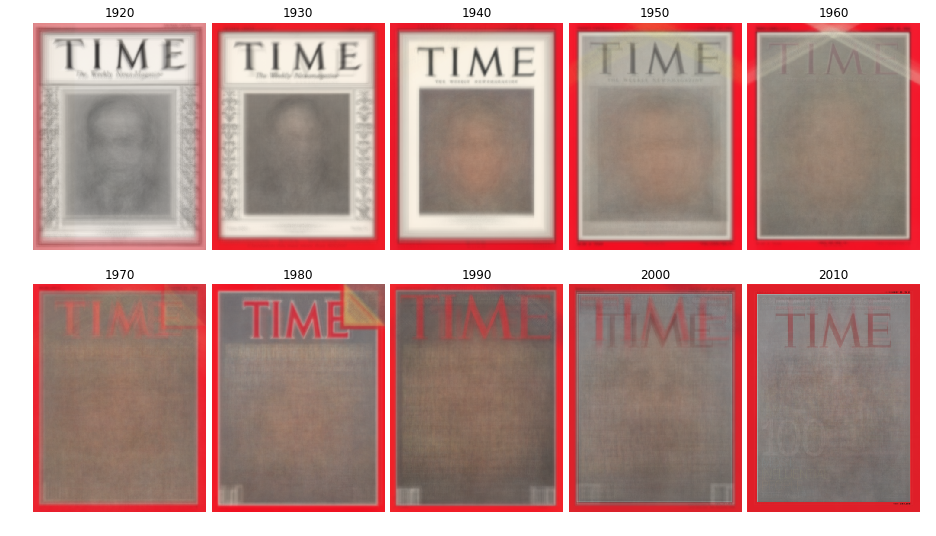

In [8]:
#plot decade averages
fig, axs = plt.subplots(2,5, figsize=(16, 9), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .15, wspace=.0001)
axs = axs.ravel()
for x, decade in zip(range(0,10),np.arange(1920, 2020, 10)):
    # load image
    p = "{}.png".format(decade)
    image = cv2.imread(p)
    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
    axs[x].set_title(str(decade))
    axs[x].axis('off')
    axs[x].imshow(draw)

In [11]:
# Loop through all images store in large list for clustering also store decade indentifier
covers = []
decade_labels = []
# loop over all
for row in data:
    # load the image
    cover = cv2.imread("output/{}".format(row["files"][0]["path"]))
     
    # if the image is None, then there was an issue loading it
    # (this happens for ~3 images in the dataset, likely due to
    # a download problem during the scraping process)
    if cover is not None:
            # resize the magazine cover (smaller for kmeans), flatten it into a single
            # list, and update the list of decade labels
            cover = cv2.resize(cover, (64,64)).flatten()
            covers.append(cover)
            label_date = row['pubDate']
            decade_labels.append(label_date)
# convert to numpy array for clustering
data_covers = np.array(covers)

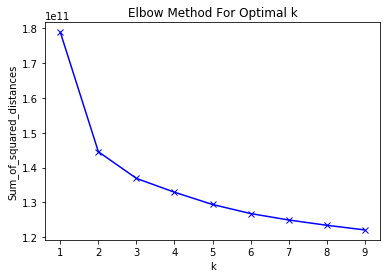

In [12]:
# Determine number of groups "K" for kmeans
# Using Elbow method - compute and store sum of squared distances for different K's
# This takes a long time...
Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    kmeans = KMeans(n_clusters=k,random_state=0)
    cluster = kmeans.fit_predict(data_covers)
    # store inertia
    Sum_of_squared_distances.append(kmeans.inertia_)
    
# plot elbow for kmean
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [14]:
# perform kmeans assuming ~6 groups based on elbow method 
# probably could be less but want to see some comparison to these groups and the decade averages
kmeans = KMeans(n_clusters=6,random_state=0)
cluster = kmeans.fit_predict(data_covers)
# reshape centroids into image format
centers = kmeans.cluster_centers_.reshape((6,64,64, 3))

In [16]:
# save out "centroids"
for x in range(0,6):
    test=centers[x]
    p = "output/test_6_{}.png".format(x)
    cv2.imwrite(p, test)  

In [17]:
# plot centroids
#imagesList=''.join( ["<img style='width: 90px; margin: 0px; float: left; border: 1px solid black;' src='%s' />" % str(s) 
#                 for s in sorted(glob('output/test_6_*.png')) ])
#display(HTML(imagesList))

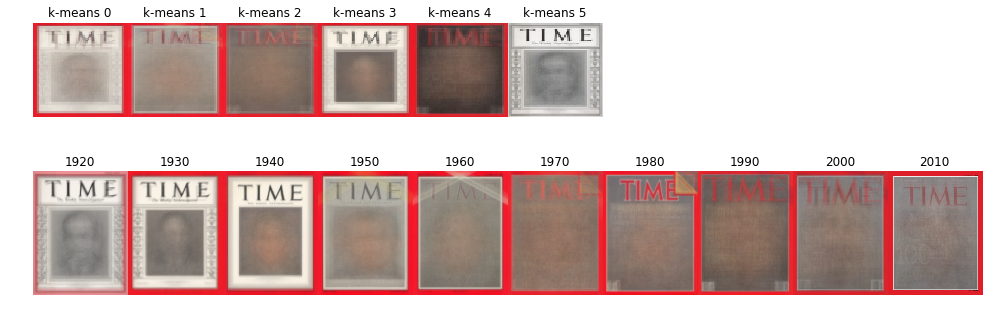

In [18]:
#plot centroids and decade average for comparison
fig, axs = plt.subplots(2,10, figsize=(17, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .002, wspace=.01)

axs = axs.ravel()

for x in range(0,6):
    # load image
    p = "output/test_6_{}.png".format(x)
    image = cv2.imread(p)
    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
    axs[x].set_title("k-means {}".format(x))
    axs[x].axis('off')
    axs[x].imshow(draw)
for i in range(6,10):
    axs[i].set_visible(False)
    
for x, decade in zip(range(10,20),np.arange(1920, 2020, 10)):
    # load image
    p = "{}.png".format(decade)
    image = cv2.imread(p)
    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
    axs[x].set_title(str(decade))
    axs[x].axis('off')
    axs[x].imshow(draw)

In [19]:
# Show original averaged images by decade
#imagesList=''.join( ["<img style='width: 90px; margin: 0px; float: left; border: 1px solid black;' src='%s' />" % str(s) 
#                 for s in sorted(glob('*.png')) ])
#display(HTML(imagesList))

In [20]:
# Convert year from decade label to np array for plotting
year_labels = [item[:4] for item in decade_labels]
year_data=np.array(year_labels)
year_data=np.asfarray(year_data,float)

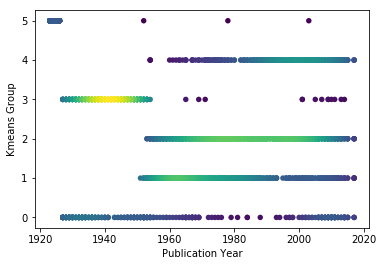

In [21]:
# Plot density scatter of publication year and k-means group
# Plot with point density
xy = np.vstack([year_data,kmeans.labels_])
z = gaussian_kde(xy)(xy)
idx = z.argsort()
x, y, z = year_data[idx], kmeans.labels_[idx], z[idx]
fig, ax1 = plt.subplots()
cax=ax1.scatter(x, y, c=z, s=30, edgecolor='')
# fig.colorbar(cax)
plt.xlabel('Publication Year')
plt.ylabel('Kmeans Group')
plt.show()

In [22]:
from sklearn.mixture import GaussianMixture 
# try Gaussian mixture models
# perform GMM assuming 6 components based on kmeans
# Use diagonal covariance for speed - losing a lot of information here
gmm2 = GaussianMixture(n_components=6,covariance_type='diag')
gmm_means = gmm2.fit(data_covers)
gmm_labels = gmm2.predict(data_covers)

In [23]:
# save means of GMM
# reshape means into image format
centers_gmm = gmm2.means_.reshape((6,64,64, 3))
# save out "centroids"
for x in range(0,6):
    test=centers_gmm[x]
    p = "output/gmm_6_{}.png".format(x)
    cv2.imwrite(p, test)  

In [24]:
#imagesList=''.join( ["<img style='width: 90px; margin: 0px; float: left; border: 1px solid black;' src='%s' />" % str(s) 
#                for s in sorted(glob('output/*gmm_6_*')) ])
#display(HTML(imagesList))

In [25]:
#imagesList=''.join( ["<img style='width: 90px; margin: 0px; float: left; border: 1px solid black;' src='%s' />" % str(s) 
#                 for s in sorted(glob('output/*test_6_*.png')) ])
#display(HTML(imagesList))

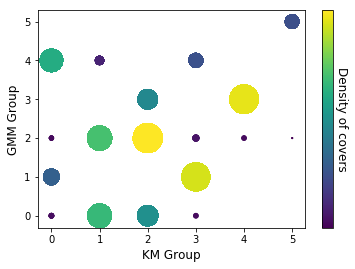

In [55]:
# Compare kmeans groups with GMM groups
xy = np.vstack([kmeans.labels_,gmm_labels])
z = gaussian_kde(xy)(xy)
idx = z.argsort()
x, y, z = kmeans.labels_[idx], gmm_labels[idx], z[idx]
fig, ax1 = plt.subplots()

cax=ax1.scatter(x, y, c=z, s=z*5000, edgecolor='')
# colorbar

cbar = plt.colorbar(cax)
cbar.set_label('Density of covers', rotation=270, labelpad=15,size=12)
cbar.ax.set_yticklabels([])
cbar.set_ticks([])

#fig.colorbar(cax)
plt.xlabel('KM Group',size=12)
plt.ylabel('GMM Group',size=12)
plt.show()

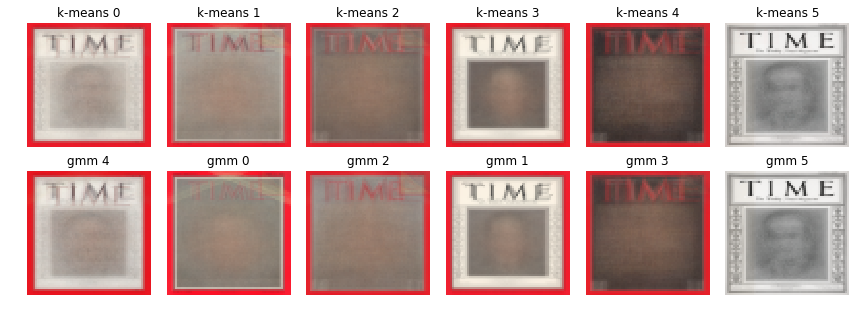

In [57]:
#plot K means centroids vs GMM means
fig, axs = plt.subplots(2,6, figsize=(15, 5), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .2, wspace=.01)

axs = axs.ravel()

for x in range(0,6):
    # load image
    p = "output/test_6_{}.png".format(x)
    image = cv2.imread(p)
    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
    axs[x].set_title("k-means {}".format(x))
    axs[x].axis('off')
    axs[x].imshow(draw)
# reorder based on scatter plots
reorder=[4,0,2,1,3,5]
for x in range(0,6):
    # load image
    p = "output/gmm_6_{}.png".format(reorder[x])
    image = cv2.imread(p)
    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
    axs[x+6].set_title("gmm {}".format(reorder[x]))
    axs[x+6].axis('off')
    axs[x+6].imshow(draw)

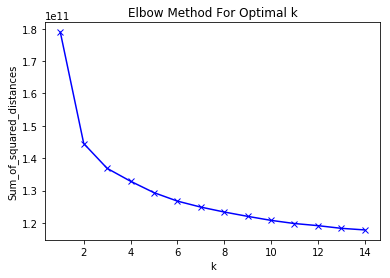

In [19]:
# kmeans elbow test for more K's
# WARNING this takes a long time
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    kmeans = KMeans(n_clusters=k,random_state=0)
    cluster = kmeans.fit_predict(data_covers)
    # store inertia
    Sum_of_squared_distances.append(kmeans.inertia_)
    
# plot elbow for kmean
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()